In [1]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt, ticker
from pysar.simulation.plot import *
from pysar.objects import timeseries, ifgramStack, sensor
from pysar.utils import readfile, ptime, plot as pp, writefile


work_dir = '/Users/yunjunz/development/python/2018_ComputGeosci_PySAR/pysar_vs_giant'
os.chdir(work_dir)
print('Go to directory: '+work_dir)

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/pysar_vs_giant


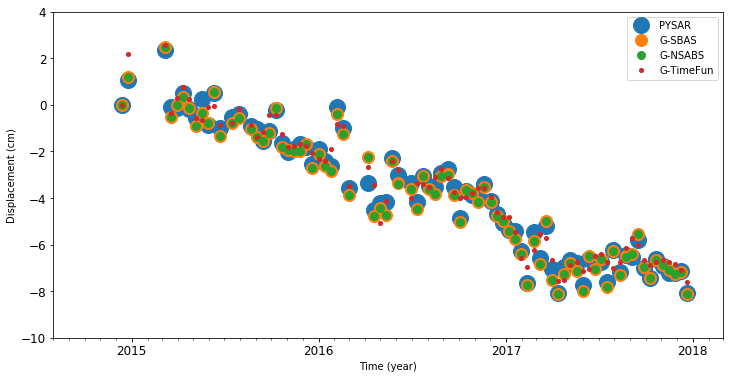

In [27]:
## One pixel with displacement time-series
y, x = 295, 395
#y, x = 306, 431
#y, x = 596, 160

project_dir = '/Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/'
ts_files = [project_dir+'PYSAR/timeseries_ECMWF_demErr_refDate_plane.h5',
            project_dir+'GIANT/Stack/LS-PARAMS.h5',
            project_dir+'GIANT/Stack/NSBAS-PARAMS.h5',
            project_dir+'GIANT/Stack/TS-PARAMS.h5',
           ]

labels = ['PYSAR', 'G-SBAS', 'G-NSABS', 'G-TimeFun']
unit_scales = [100., 0.1, 0.1, 0.1]
ms_list = [16, 12, 8, 4]
colors = pp.mplColors[0:4]

atr = readfile.read_attribute(ts_files[0])
date_list = timeseries(ts_files[0]).get_date_list()
dates, datevector = ptime.date_list2vector(date_list)
box = [x, y, x+1, y+1]
fig, ax = plt.subplots(figsize=[12, 6])
for i in [0,1,2,3]:
    dis_ts = readfile.read(ts_files[i], box=box, print_msg=False)[0] * unit_scales[i]
    dis_ts -= dis_ts[0]
    #dis_ts += i * 2
    ax.plot(dates, dis_ts, 'o', label=labels[i], ms=ms_list[i])#, mfc='None')
pp.auto_adjust_xaxis_date(ax, datevector)
ax.set_ylim(-10, 4)
ax.set_xlabel('Time (year)')
ax.set_ylabel('Displacement (cm)')
plt.legend()

out_file= 'Y{}X{}_AlcedoSen.jpg'.format(y, x)
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

reading height data from file: /Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/PYSAR/INPUTS/geometryRadar.h5 ...


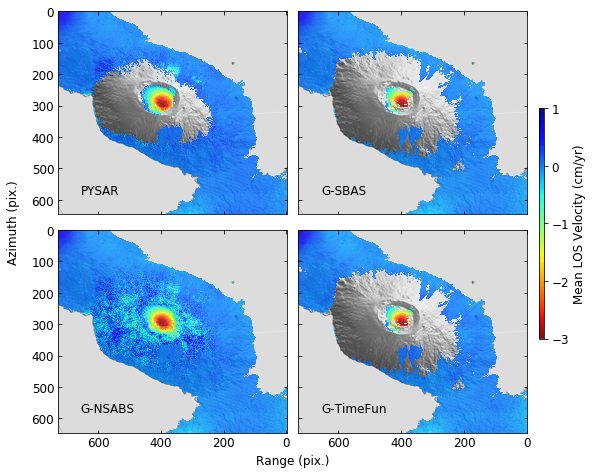

In [26]:
## Linear Velocity Map

ts_files = [project_dir+'PYSAR/velocity_masked.h5',
            project_dir+'GIANT/Stack/LS-velocity.h5',
            project_dir+'GIANT/Stack/NSBAS-velocity.h5',
            project_dir+'GIANT/Stack/TS-velocity.h5',
           ]

dem_file = project_dir+'PYSAR/INPUTS/geometryRadar.h5'
dem = readfile.read(dem_file, datasetName='height')[0]
pdict = {}
pdict['disp_dem_contour'] = False

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharex=True, sharey=True, squeeze=True)
for i in [0,1,2,3]:
    row = int(i / 2)
    col = i % 2
    axi = ax[row, col]
    axi = pp.plot_dem_background(ax=axi, geo_box=None, dem=dem,
                                 inps_dict=pdict, print_msg=False)
    data = readfile.read(ts_files[i], datasetName='velocity')[0] * 100.
    im = axi.imshow(data, cmap='jet_r', vmin=-3, vmax=1, alpha=0.8)
    axi.invert_xaxis()
    axi.tick_params(which='both', direction='in', labelsize=font_size,
                    bottom=True, top=True, left=True, right=True)
    axi.annotate(labels[i], xy=(0.1, 0.1), color='k', xycoords='axes fraction', fontsize=font_size)
plt.subplots_adjust(right=0.94, wspace=0.05, hspace=0.01)
cax = fig.add_axes([0.96, 0.3, 0.01, 0.4])
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=font_size)
cbar.locator = ticker.MaxNLocator(nbins=4)
cbar.update_ticks()
cbar.set_label('Mean LOS Velocity (cm/yr)', fontsize=font_size)

pp.set_shared_xlabel(ax.flatten(), 'Range (pix.)',   labelpad=-0.1, position='bottom')
pp.set_shared_ylabel(ax.flatten(), 'Azimuth (pix.)', labelpad=-0.06)

out_file= 'vel_AlcedoSen.jpg'
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)

plt.show()

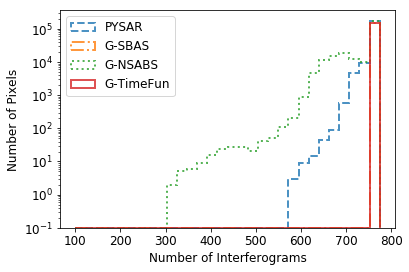

In [8]:
## Histogram of pixels used in network inversion
project_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/'
project_dir = '/Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/'
project_name = sensor.project_name2sensor_name(project_dir)[1]

mask_file = project_dir+'PYSAR/maskTempCoh.h5'
mask = readfile.read(mask_file)[0].flatten()
num_inv_ifgram_file = project_dir+'PYSAR/numInvIfgram.h5'
num_inv_ifgram = readfile.read(num_inv_ifgram_file)[0].flatten()
num_inv_ifgram[mask == 0] = 0
num_inv_ifgram = num_inv_ifgram[num_inv_ifgram != 0.]


num_ifgram_file = project_dir+'PYSAR/numIfgram.h5'
num_ifg = readfile.read(num_ifgram_file)[0].flatten()
num_ifg = num_ifg[num_ifg != 0.]

num_ifg_max = 775
nthres = 300

# GIANT
num_gsbas = num_ifg[num_ifg == num_ifg_max]
num_gtimefun = num_ifg[num_ifg == num_ifg_max]
num_gnsbas = num_ifg[num_ifg >= nthres]
num_pysar = num_inv_ifgram

num_data = (num_pysar, num_gsbas, num_gnsbas, num_gtimefun)
labels = ['PYSAR', 'G-SBAS', 'G-NSABS', 'G-TimeFun']
linestyles = ('dashed', 'dashdot', 'dotted', 'solid')

fig, ax = plt.subplots(figsize=(6, 4))
for i in [0, 1, 2, 3]:
    ax.hist(num_data[i], bins=30, histtype='step', 
            range=(100,num_ifg_max), log=True,
            color=pp.mplColors[i],
            label=labels[i], alpha=0.8, lw=2, linestyle=linestyles[i])
ax.tick_params(which='both', labelsize=font_size)
plt.legend(loc='upper left', fontsize=font_size)
plt.xlabel('Number of Interferograms', fontsize=font_size)
plt.ylabel('Number of Pixels', fontsize=font_size)

out_file = 'hist_num_ifgram_{}.jpg'.format(project_name)
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

In [68]:
## Calculate number of pixels used in inversion in pysar and giant
project_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/'
project_dir = '/Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/'
cthres = 0.25

water_mask_file = project_dir+'PYSAR/waterMask.h5'
water_mask = readfile.read(water_mask_file)[0]

ifgram_file = project_dir+'PYSAR/INPUTS/ifgramStack.h5'
stack_obj = ifgramStack(ifgram_file)
stack_obj.open()

num_ifgram = np.zeros((stack_obj.length, stack_obj.width), np.int16)

for i in range(stack_obj.numIfgram):
    date12 = stack_obj.date12List[i]
    unw = stack_obj.read(datasetName='unwrapPhase-{}'.format(date12), print_msg=False)
    cor = stack_obj.read(datasetName='coherence-{}'.format(date12), print_msg=False)
    unw[water_mask == 0] = 0
    unw[cor < 0.25] = 0.
    num_map = unw != 0
    num_ifgram += num_map
    sys.stdout.write('\rifgram {}/{}'.format(i+1, stack_obj.numIfgram))
    sys.stdout.flush()
print('')
num_inv_ifgram_file = project_dir+'/PYSAR/numInvIfgram.h5'
out_file = project_dir+'/PYSAR/numIfgram.h5'
writefile.write(num_ifgram, out_file=out_file, ref_file=num_inv_ifgram_file)

open ifgramStack file: ifgramStack.h5
ifgram 775/775
create HDF5 file: /Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128//PYSAR/numIfgram.h5 with w mode
create dataset /mask of int16      in size of (646, 729) with compression=None
finished writing to /Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128//PYSAR/numIfgram.h5
